# STEM Employment and Labor Market Outcomes in the U.S.

**Georgetown University**  
McCourt School of Public Policy  
**Spring 2025**  

**Author:** Yihan Chen  
**Advisor:** Prof. Ani Rudra Silwal  
**Date:** May 1, 2025  

# **1 Data Setup**

## 1-1 Import required libraries

In [ ]:
# !pip install openpyxl

import pandas as pd
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
# !pip install statsmodels --upgrade
from statsmodels.iolib.summary2 import summary_col  # Import summary_col
from patsy import dmatrices

## 1-2 Connect Google Drive to Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 1-3 Load the dataset

In [ ]:
file_path = '/content/drive/My Drive/job/cps_00003.dta'
df = pd.read_stata(file_path)

## 1-4 Display the first five lines of the dataset

In [ ]:
print(df.head())

   year  serial  month         cpsid asecflag  asecwth  pernum        cpsidp  \
0  2023       1  march  2.022010e+13     asec  1580.07       1  2.022010e+13   
1  2023       1  march  2.022010e+13     asec  1580.07       2  2.022010e+13   
2  2023       2  march  2.023010e+13     asec  1789.60       1  2.023010e+13   
3  2023       2  march  2.023010e+13     asec  1789.60       2  2.023010e+13   
4  2023      10  march  2.022020e+13     asec  1307.92       1  2.022020e+13   

         cpsidv   asecwt  ...      citizen               empstat   occ   ind  \
0  2.022010e+14  1580.07  ...  born in u.s         nilf, retired     0     0   
1  2.022010e+14  1580.07  ...  born in u.s         nilf, retired     0     0   
2  2.023010e+14  1789.60  ...  born in u.s  nilf, unable to work     0     0   
3  2.023010e+14  1789.60  ...  born in u.s               at work  4760  4690   
4  2.022020e+14  1307.92  ...  born in u.s         nilf, retired     0     0   

               classwkr uhrsworkt    u

## 1-5 Find out the number of rows and columns

In [ ]:
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset contains 146133 rows and 26 columns.


## 1-6 Display the list of all variables

In [ ]:
print(df.columns.tolist())

['year', 'serial', 'month', 'cpsid', 'asecflag', 'asecwth', 'pernum', 'cpsidp', 'cpsidv', 'asecwt', 'earnweek2', 'hourwage2', 'age', 'sex', 'race', 'marst', 'citizen', 'empstat', 'occ', 'ind', 'classwkr', 'uhrsworkt', 'uhrswork1', 'educ', 'diffany', 'incwage']


In [ ]:
# prompt: Check for missing values

# Check for missing values
print(df.isnull().sum())
print(df.isnull().sum().sum())


year         0
serial       0
month        0
cpsid        0
asecflag     0
asecwth      0
pernum       0
cpsidp       0
cpsidv       0
asecwt       0
earnweek2    0
hourwage2    0
age          0
sex          0
race         0
marst        0
citizen      0
empstat      0
occ          0
ind          0
classwkr     0
uhrsworkt    0
uhrswork1    0
educ         0
diffany      0
incwage      0
dtype: int64
0


# **2 Create STEM Occupation Variable**

## 2-1 Upload Stem List

In [ ]:
file_path_stem = '/content/drive/My Drive/job/stem.xlsx'
stem = pd.read_excel(file_path_stem, na_values=[], keep_default_na=False)

In [ ]:
print("df columns:", df.columns.tolist())
print("stem columns:", stem.columns.tolist())

df columns: ['year', 'serial', 'month', 'cpsid', 'asecflag', 'asecwth', 'pernum', 'cpsidp', 'cpsidv', 'asecwt', 'earnweek2', 'hourwage2', 'age', 'sex', 'race', 'marst', 'citizen', 'empstat', 'occ', 'ind', 'classwkr', 'uhrsworkt', 'uhrswork1', 'educ', 'diffany', 'incwage']
stem columns: ['name', 'code_2018', 'stem_type']


In [ ]:
print(df['occ'].unique()[:20])

[   0 4760 4220 2145 8990 2014  410  340 3603 7010 4600 7330 3255 4210
  420 2910  440  230 2013 4700]


In [ ]:
print(df[df['occ'] == 0]['empstat'].value_counts())

empstat
niu                               29483
nilf, retired                     22080
nilf, other                       16993
nilf, unable to work               5280
armed forces                        465
unemployed, new worker              180
unemployed, experienced worker        0
at work                               0
has job, not at work last week        0
Name: count, dtype: int64


In [ ]:
tab_result = stem['stem_type'].value_counts(dropna=False).reset_index()
tab_result.columns = ['stem_type', 'count']
print(tab_result)

  stem_type  count
0      None    451
1      STEM     70
2   Related     49


## 2-2 Merge

In [ ]:
# Check type and example values for df['occ']
print("df['occ'] type:", df['occ'].dtype)
print("Sample df['occ'] values:", df['occ'].unique()[:5])

# Check type and sample for stem['code_2018']
print("stem['code_2018'] type:", stem['code_2018'].dtype)
print("Sample stem['code_2018'] values:", stem['code_2018'].unique()[:5])

df['occ'] type: int16
Sample df['occ'] values: [   0 4760 4220 2145 8990]
stem['code_2018'] type: int64
Sample stem['code_2018'] values: [10 20 30 40 51]


In [ ]:
df['occ_str'] = df['occ'].astype(str).str.zfill(4)
stem['occ_str'] = stem['code_2018'].astype(str).str.zfill(4)

In [ ]:
print(stem.columns.tolist())

['name', 'code_2018', 'stem_type', 'occ_str']


In [ ]:
stem_unique = stem[['occ_str', 'stem_type']].drop_duplicates()
print(stem_unique.head())

  occ_str stem_type
0    0010      None
1    0020      None
2    0030      None
3    0040      None
4    0051      None


In [ ]:
df = df.merge(stem_unique, how='left', on='occ_str')

In [ ]:
print(df[['occ', 'occ_str', 'stem_type']].head())

    occ occ_str stem_type
0     0    0000       NaN
1     0    0000       NaN
2     0    0000       NaN
3  4760    4760      None
4     0    0000       NaN


In [ ]:
print(df['stem_type'].value_counts(dropna=True))

stem_type
None       61363
STEM        5296
Related     4989
Name: count, dtype: int64


In [ ]:
print(df['stem_type'].value_counts(dropna=False))

stem_type
NaN        74485
None       61363
STEM        5296
Related     4989
Name: count, dtype: int64


This is similar to "tab empstat if occ == 0". The obs is 7,4481.

# **3 Data Preprocessing**

**DATA WRANGLING & VARIABLE RECODING**:
1. This script processes the `df_working` dataset by filtering working individuals,
2. cleaning and recoding key variables for modeling and visualization purposes.

**Methodology Overview**:
1. I first restrict the dataset to individuals in the labor force, defined as：those currently 'at work' or who 'have a job but not at work last week'.

2. I then clean and recode variables to construct interpretable and policy-relevant categories. This includes age grouping, simplified education levels, race and citizenship categories, marital status, class of work, and usual hours worked.

3. Income variables (annual and hourly) are converted to numeric, and topcoded or invalid values are removed where appropriate.

4. Industry is classified into five macro sectors using Census industry codes.

“At the top level, they are often classified according to the three-sector theory into sectors: primary (extraction and agriculture), secondary (manufacturing), and tertiary (services). Some authors add quaternary (knowledge) or even quinary (culture and research) sectors.”

https://www.census.gov/programs-surveys/aces/information/iccl.html

5. The dataset is reordered into logical column groups: outcomes, predictors, controls, and identifiers.

6. Visualization and tabulation functions are provided to analyze the proportion of individuals in various categories (e.g., STEM type by age group or race).


Reference Groups for Regression Analysis:

• stem_type → None

• citizen_recode → Non-Citizen

• age_group → 15–24

• sex → male

• educ_simple → High School or Less

• race_recode → White

• marst_recode → Married

• classwkr_recode → Government Employee

• industry_sector → Quinary

• worktime_group → Full-Time

## 3-1 Recode key variables

In [ ]:
# Function: Recode and classify all key variables for df_working
def clean_and_classify_working_data(df):
    # Step 1: Filter working individuals
    df_working = df[df['empstat'].isin(['at work', 'has job, not at work last week'])].copy()

    # Step 2: Age cleaning and grouping
    df_working['age_clean'] = df_working['age'].replace('under 1 year', 0).astype(int)
    bins = [15, 25, 35, 45, 55, 65, 100]
    labels = ['15-24', '25-34', '35-44', '45-54', '55-64', '65+']
    df_working['age_group'] = pd.cut(df_working['age_clean'], bins=bins, labels=labels)

    # Step 3: Education recode
        # Collapses educational attainment into 5 categories:
    # - High School or Less (≤12th grade or equivalent)
    # - Associate's Degree (vocational or academic)
    # - Bachelor's Degree
    # - Graduate Degree (master's/professional/doctorate)
    # - Other/Blank

    def recode_educ(val):
        if val in [
            'none or preschool', 'grades 1, 2, 3, or 4', 'grades 5 or 6',
            'grades 7 or 8', 'grade 9', 'grade 10', 'grade 11',
            '12th grade, no diploma', 'high school diploma or equivalent'
        ]:
            return 'High School or Less'
        elif val in ["associate's degree, occupational/vocati", "associate's degree, academic program"]:
            return "Associate's Degree"
        elif val == "bachelor's degree":
            return "Bachelor's Degree"
        elif val in ["master's degree", "professional school degree", "doctorate degree"]:
            return "Graduate Degree"
        else:
            return 'Other/Blank'

    df_working['educ_simple'] = df_working['educ'].apply(recode_educ)

    # Step 4: Race recode
    # Simplified into: White, Black, Asian (matches on string), and Other
    def recode_race(val):
        if val == 'white': return 'White'
        elif val == 'black': return 'Black'
        elif 'asian' in str(val).lower(): return 'Asian'
        else: return 'Other'

    df_working['race_recode'] = df_working['race'].apply(recode_race)

    # Step 5: Marital status recode
    # Recoded as:
    # - Married (spouse present)
    # - Never Married (never married/single)
    # - Formerly Married (divorced, separated, widowed, spouse absent)

    def recode_marst(val):
        if val == 'married, spouse present': return 'Married'
        elif val == 'never married/single': return 'Never Married'
        else: return 'Formerly Married'

    df_working['marst_recode'] = df_working['marst'].apply(recode_marst)

    # Step 6: Citizenship recode
    # Recoded as:
    # - U.S. Born (includes U.S. territories and abroad to American parents)
    # - Naturalized Citizen
    # - Non-Citizen
    # - Other (undefined or missing)
    def recode_citizen(val):
        if val in ['born in u.s', 'born abroad of american parents', 'born in u.s. outlying']:
            return 'U.S. Born'
        elif val == 'naturalized citizen':
            return 'Naturalized Citizen'
        else:
            return 'Non-Citizen'

    df_working['citizen_recode'] = df_working['citizen'].apply(recode_citizen)

    # Step 7: Class of worker recode
    # Recoded as:
    # - Private Sector
    # - Government Employee (federal, state, or local)
    # - Self-Employed/Others (all remaining types)
    def recode_classwkr(val):
        if val == 'wage/salary, private':
            return 'Private Sector'
        elif val in ['federal government employee', 'state government employee', 'local government employee']:
            return 'Government Employee'
        else:
            return 'Self-Employed/Others'

    df_working['classwkr_recode'] = df_working['classwkr'].apply(recode_classwkr)

    # Step 8: Usual work hours cleaning and grouping
    # Groups 'uhrsworkt' into:
    # - <30 hours
    # - 30-39 hours
    # - 40 hours
    # - 41-49 hours
    # - 50+ hours
    # - Other (invalid or missing values)
    df_working['uhrsworkt_clean'] = pd.to_numeric(df_working['uhrsworkt'], errors='coerce')

    def recode_hours(val):
        if pd.isna(val):
            return 'Other'
        elif val < 30:
            return '<30 hours'
        elif 30 <= val <= 39:
            return '30-39 hours'
        elif val == 40:
            return '40 hours'
        elif 41 <= val <= 49:
            return '41-49 hours'
        elif val >= 50:
            return '50+ hours'
        else:
            return 'Other'

    df_working['uhrsworkt_group'] = df_working['uhrsworkt_clean'].apply(recode_hours)

    # Classifies work hours into:
    # - Part-Time (<35 hrs)
    # - Full-Time (35–49 hrs)
    # - Long Hours (50+ hrs)
    # - Unknown (missing or invalid)

    def classify_worktime(hours):
        try:
            hours = float(hours)
            if pd.isna(hours):
                return 'Unknown'
            elif hours < 35:
                return 'Part-Time'
            elif hours <= 49:
                return 'Full-Time'
            else:
                return 'Long Hours'
        except:
            return 'Unknown'

    df_working['worktime_group'] = df_working['uhrsworkt'].apply(classify_worktime)

    # Step 9: Industry sector mapping
    # Maps Census industry codes into:
    # - Primary (agriculture, mining)
    # - Secondary (construction, manufacturing)
    # - Tertiary (services)
    # - Quaternary (information, finance, prof. services)
    # - Quinary (govt, nonprofits, undefined)
    def map_industry_sector(ind_code):
        if 170 <= ind_code <= 290:
            return 'Primary'
        elif 370 <= ind_code <= 3990:
            return 'Secondary'
        elif 4070 <= ind_code <= 7790:
            return 'Tertiary'
        elif 7860 <= ind_code <= 8470:
            return 'Quaternary'
        else:
            return 'Quinary'

    df_working['industry_sector'] = df_working['ind'].apply(map_industry_sector)

    # Note: STEM Type is an existing variable assumed to be preclassified into 3 categories:
# - STEM: Core science, technology, engineering, and mathematics occupations
# - Related: STEM-adjacent roles (e.g., health technicians, technical sales)
# - None: Non-STEM occupations

    # Step 10: Reorder columns for modeling and analysis
    ordered_columns = [
        'empstat', 'incwage', 'hourwage2', 'stem_type',
        'age_group', 'sex', 'educ_simple', 'race_recode', 'marst_recode', 'citizen_recode',
        'classwkr_recode', 'uhrsworkt', 'diffany', 'industry_sector', 'worktime_group',
        'age_clean', 'year', 'month', 'serial', 'pernum', 'cpsid', 'cpsidp', 'cpsidv',
        'asecflag', 'asecwth', 'asecwt', 'age', 'uhrswork1', 'occ', 'occ_str', 'earnweek2',
        'race', 'educ', 'marst', 'citizen', 'classwkr', 'ind', 'uhrsworkt_group'
    ]
    df_working = df_working[[col for col in ordered_columns if col in df_working.columns]]

        # Step 11: Clean income variables
            # Ensures income variables are numeric
    df_working['incwage'] = pd.to_numeric(df_working['incwage'], errors='coerce')
    df_working['hourwage2'] = pd.to_numeric(df_working['hourwage2'], errors='coerce')  # move here

        # Step 12: Add additional regression-ready variables
    df_working['diffany_dummy'] = (df_working['diffany'] == 'has difficulty').astype(int)
    df_working['log_incwage'] = np.log(df_working['incwage'].replace(0, np.nan))
    df_working = df_working.dropna(subset=['log_incwage'])

            # Step 13: Set meaningful reference categories for regression (ordered factors)
    df_working['stem_type'] = pd.Categorical(df_working['stem_type'], categories=['None', 'Related', 'STEM'], ordered=True)
    df_working['age_group'] = pd.Categorical(df_working['age_group'], categories=['15-24', '25-34', '35-44', '45-54', '55-64', '65+'], ordered=True)
    df_working['sex'] = pd.Categorical(df_working['sex'], categories=['male', 'female'])
    df_working['educ_simple'] = pd.Categorical(df_working['educ_simple'], categories=['High School or Less', "Associate's Degree", "Bachelor's Degree", "Graduate Degree", 'Other/Blank'], ordered=True)
    df_working['race_recode'] = pd.Categorical(df_working['race_recode'], categories=['White', 'Black', 'Asian', 'Other'])
    df_working['marst_recode'] = pd.Categorical(df_working['marst_recode'], categories=['Married', 'Never Married', 'Formerly Married'])
    df_working['classwkr_recode'] = pd.Categorical(df_working['classwkr_recode'], categories=['Government Employee', 'Private Sector', 'Self-Employed/Others'])
    df_working['industry_sector'] = pd.Categorical(df_working['industry_sector'], categories=['Quinary', 'Quaternary', 'Tertiary', 'Secondary', 'Primary'], ordered=True)
    df_working['worktime_group'] = pd.Categorical(df_working['worktime_group'], categories=['Full-Time', 'Part-Time', 'Long Hours', 'Unknown'])
    df_working['citizen_recode'] = pd.Categorical(df_working['citizen_recode'], categories=['Non-Citizen', 'U.S. Born', 'Naturalized Citizen'])


    # Step 14: Create cleaned dataset for hourwage2 analysis only
    df_hourwage = df_working.copy()
    df_hourwage = df_hourwage[df_hourwage['hourwage2'] < 999]  # remove topcoded values

    return df_working, df_hourwage

In [ ]:
df_working, df_hourwage = clean_and_classify_working_data(df)

<ipython-input-121-9eb7c0d599b7>:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_working['age_clean'] = df_working['age'].replace('under 1 year', 0).astype(int)


## 3-2 Summary of Variables

In [ ]:
def summarize_variable_quality(df):
    summary = pd.DataFrame({
        'Variable': df.columns,
        'Type': df.dtypes.values,
        'Missing (%)': df.isnull().mean().round(4) * 100,
        'Unique Values': df.nunique()
    })
    return summary.sort_values(by='Missing (%)', ascending=False)

In [ ]:
summary_table = summarize_variable_quality(df_working)
display(summary_table)

,Variable,Type,Missing (%),Unique Values
age_group,age_group,category,0.17,6
empstat,empstat,category,0.00,2
hourwage2,hourwage2,float64,0.00,407
incwage,incwage,int32,0.00,3308
stem_type,stem_type,category,0.00,3
sex,sex,category,0.00,2
educ_simple,educ_simple,category,0.00,5
race_recode,race_recode,category,0.00,4
marst_recode,marst_recode,category,0.00,3
citizen_recode,citizen_recode,category,0.00,3


# **4 Descriptive Statistics**

## 4-1 Functions for Plots

### 4-1-1 Tabulate and Plot Distrubution

In [ ]:
# Function: Tabulate and plot proportional distribution
def tabulate_and_plot(df, var, order=None, title='', xlabel=''):
    tab = df[var].value_counts(normalize=True).rename_axis(var).reset_index(name='Proportion')

    plt.figure(figsize=(8, 5))
    sns.barplot(data=tab, x=var, y='Proportion', order=order, palette='Set2')
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel or var.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Proportion (%)', fontsize=12)
    plt.ylim(0, tab['Proportion'].max() + 0.05)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    return tab

### 4-1-2 Plot STEM Type by Others

In [ ]:
# Function: Plot stacked bar of STEM type by another categorical variable
def plot_stem_share_by(df, by_var, order=None, title=''):
    tab = (
        df.groupby(by_var, observed=False)['stem_type']
        .value_counts(normalize=True)
        .rename('Proportion')
        .reset_index()
    )
    tab['Proportion'] *= 100

    plt.figure(figsize=(8, 5))
    sns.barplot(data=tab, x=by_var, y='Proportion', hue='stem_type', order=order, hue_order=['STEM', 'Related', 'None'], palette='Set2')
    plt.title(title, fontsize=14)
    plt.xlabel(by_var.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xticks(rotation=30)
    plt.ylim(0, 100)
    plt.legend(title='STEM Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

### 4-1-3 Boxplot of income variables by STEM type

In [ ]:
# Function: Boxplot of income variables by STEM type
def plot_income_box(df, income_var, title='', ylabel=''):
    plt.figure(figsize=(8, 5))
    sns.boxplot(
        data=df,
        x='stem_type',
        y=income_var,
        palette='Pastel1'
    )
    plt.title(title, fontsize=14)
    plt.xlabel('STEM Type', fontsize=12)
    plt.ylabel(ylabel or income_var.replace('_', ' ').title(), fontsize=12)
    plt.ylim(0, df[income_var].quantile(0.95))
    plt.tight_layout()
    plt.show()

    medians = df.groupby('stem_type')[income_var].median()
    print(f"Median {income_var} by STEM type: ", medians)

### 4-1-4 Tabulate Function

In [ ]:
vars_to_crosstab = [
    'educ_simple',         # 4-2-1 Education
    'race_recode',         # 4-2-2 Race
    'marst_recode',        # 4-2-3 Marriage Status
    'citizen_recode',      # 4-2-4 Citizenship
    'classwkr_recode',     # 4-2-5 Class of Work
    'worktime_group',      # 4-2-6 Work Time Group
    'industry_sector',      # 4-2-7 Industry Sector
    'age_group',           # 4-2-8 Age Group
    'stem_type',
    'sex'
]

In [ ]:
def tabulate_variable_distribution(df, var, percent=True, decimals=1):
    """
    Tabulate frequency and proportion of a categorical variable.

    Parameters:
    - df: DataFrame
    - var: str, the variable name
    - percent: bool, whether to format as percent
    - decimals: int, decimal places to round

    Returns:
    - DataFrame with 'Count' and 'Proportion' columns
    """
    counts = df[var].value_counts(dropna=False).rename('Count')
    proportions = df[var].value_counts(normalize=True, dropna=False).rename('Proportion')

    result = pd.concat([counts, proportions], axis=1)

    if percent:
        result['Proportion'] = (result['Proportion'] * 100).round(decimals).astype(str) + '%'
    else:
        result['Proportion'] = result['Proportion'].round(decimals)

    result.index.name = var
    result = result.reset_index()

    print(f"\nDistribution of {var}")
    display(result)
    return result


In [ ]:
for var in vars_to_crosstab:
    if var in df_working.columns:
        tabulate_variable_distribution(df_working, var)
    else:
        print(f"⚠️ Variable '{var}' not found.")


Distribution of educ_simple


,educ_simple,Count,Proportion
0,High School or Less,21156,33.5%
1,Bachelor's Degree,15849,25.1%
2,Other/Blank,12135,19.2%
3,Graduate Degree,10051,15.9%
4,Associate's Degree,3876,6.1%



Distribution of race_recode


,race_recode,Count,Proportion
0,White,48628,77.1%
1,Black,7090,11.2%
2,Asian,5209,8.3%
3,Other,2140,3.4%



Distribution of marst_recode


,marst_recode,Count,Proportion
0,Married,34708,55.0%
1,Never Married,19375,30.7%
2,Formerly Married,8984,14.2%



Distribution of citizen_recode


,citizen_recode,Count,Proportion
0,U.S. Born,51523,81.7%
1,Non-Citizen,5878,9.3%
2,Naturalized Citizen,5666,9.0%



Distribution of classwkr_recode


,classwkr_recode,Count,Proportion
0,Private Sector,50002,79.3%
1,Government Employee,9857,15.6%
2,Self-Employed/Others,3208,5.1%



Distribution of worktime_group


,worktime_group,Count,Proportion
0,Full-Time,43001,68.2%
1,Part-Time,8933,14.2%
2,Long Hours,7849,12.4%
3,Unknown,3284,5.2%



Distribution of industry_sector


,industry_sector,Count,Proportion
0,Tertiary,23585,37.4%
1,Quaternary,15423,24.5%
2,Quinary,11661,18.5%
3,Secondary,11604,18.4%
4,Primary,794,1.3%



Distribution of age_group


,age_group,Count,Proportion
0,35-44,15267,24.2%
1,25-34,13912,22.1%
2,45-54,12933,20.5%
3,55-64,9467,15.0%
4,15-24,8036,12.7%
5,65+,3342,5.3%
6,NaN,110,0.2%



Distribution of stem_type


,stem_type,Count,Proportion
0,None,53297,84.5%
1,STEM,5052,8.0%
2,Related,4718,7.5%



Distribution of sex


,sex,Count,Proportion
0,male,32610,51.7%
1,female,30457,48.3%


In [ ]:
def crosstab_stem_by(df, by_var, normalize='index', percent=True, decimals=1):
    """
    Create a crosstab between 'stem_type' and another categorical variable.

    Parameters:
    - df: DataFrame
    - by_var: str, the variable to cross with 'stem_type'
    - normalize: str, 'index' for row %, 'columns' for column %, None for raw counts
    - percent: bool, whether to format as percent
    - decimals: int, decimal places for percent display

    Returns:
    - Crosstab DataFrame (printed and returned)
    """
    tab = pd.crosstab(df[by_var], df['stem_type'], normalize=normalize)

    if percent:
        tab = tab * 100
        tab = tab.round(decimals).astype(str) + '%'

    print(f"Cross-tabulation: {by_var} × STEM Type")
    display(tab)
    return tab

In [ ]:
for var in vars_to_crosstab:
    if var in df_working.columns:
        crosstab_stem_by(df_working, by_var=var)
    else:
        print(f"⚠️ Variable '{var}' not found in df_working.")

Cross-tabulation: educ_simple × STEM Type


stem_type,None,Related,STEM
educ_simple,,,
High School or Less,96.9%,1.5%,1.6%
Associate's Degree,81.5%,12.4%,6.1%
Bachelor's Degree,75.7%,9.6%,14.7%
Graduate Degree,67.4%,16.7%,15.9%
Other/Blank,89.7%,5.8%,4.5%


Cross-tabulation: race_recode × STEM Type


stem_type,None,Related,STEM
race_recode,,,
White,85.5%,7.4%,7.1%
Black,87.6%,7.2%,5.2%
Asian,68.8%,9.9%,21.3%
Other,90.1%,4.9%,5.0%


Cross-tabulation: marst_recode × STEM Type


stem_type,None,Related,STEM
marst_recode,,,
Married,82.0%,8.7%,9.3%
Never Married,87.6%,5.4%,7.0%
Formerly Married,87.6%,7.3%,5.1%


Cross-tabulation: citizen_recode × STEM Type


stem_type,None,Related,STEM
citizen_recode,,,
Non-Citizen,85.8%,3.3%,10.9%
U.S. Born,84.9%,7.8%,7.4%
Naturalized Citizen,79.8%,9.3%,10.9%


Cross-tabulation: classwkr_recode × STEM Type


stem_type,None,Related,STEM
classwkr_recode,,,
Government Employee,85.8%,5.8%,8.4%
Private Sector,83.8%,7.9%,8.3%
Self-Employed/Others,91.2%,5.9%,2.9%


Cross-tabulation: worktime_group × STEM Type


stem_type,None,Related,STEM
worktime_group,,,
Full-Time,82.8%,7.5%,9.7%
Part-Time,90.3%,7.8%,1.9%
Long Hours,85.3%,7.4%,7.2%
Unknown,89.3%,6.2%,4.4%


Cross-tabulation: industry_sector × STEM Type


stem_type,None,Related,STEM
industry_sector,,,
Quinary,93.2%,1.6%,5.2%
Quaternary,70.2%,26.1%,3.7%
Tertiary,86.6%,2.0%,11.3%
Secondary,89.6%,0.2%,10.2%
Primary,96.5%,0.1%,3.4%


Cross-tabulation: age_group × STEM Type


stem_type,None,Related,STEM
age_group,,,
15-24,92.2%,3.9%,4.0%
25-34,80.8%,8.7%,10.5%
35-44,82.3%,8.7%,9.0%
45-54,84.1%,7.6%,8.3%
55-64,86.2%,6.8%,7.0%
65+,87.9%,7.2%,5.0%


Cross-tabulation: stem_type × STEM Type


stem_type,None,Related,STEM
stem_type,,,
None,100.0%,0.0%,0.0%
Related,0.0%,100.0%,0.0%
STEM,0.0%,0.0%,100.0%


Cross-tabulation: sex × STEM Type


stem_type,None,Related,STEM
sex,,,
male,85.3%,3.5%,11.3%
female,83.7%,11.8%,4.5%


## 4-2 Plots for Variables

### 4-2-1 Education

<ipython-input-125-cb258bb1a3c3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tab, x=var, y='Proportion', order=order, palette='Set2')


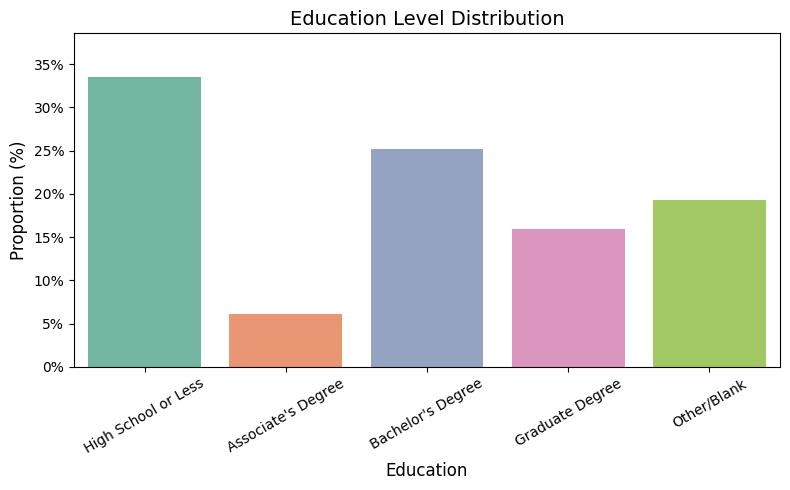

,educ_simple,Proportion
0,High School or Less,0.335453
1,Bachelor's Degree,0.251304
2,Other/Blank,0.192414
3,Graduate Degree,0.159370
4,Associate's Degree,0.061458


In [ ]:
tabulate_and_plot(df_working, 'educ_simple',
                  order=['High School or Less', "Associate's Degree", "Bachelor's Degree", "Graduate Degree", 'Other/Blank'],
                  title='Education Level Distribution', xlabel='Education')

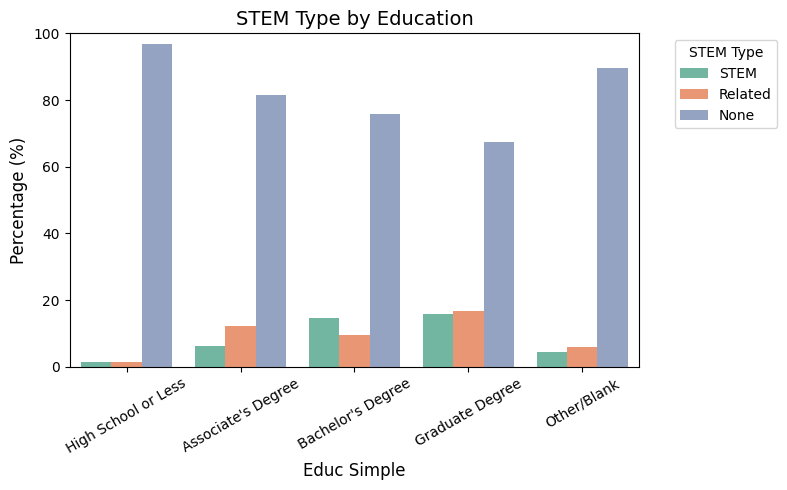

In [ ]:
plot_stem_share_by(df_working,
                   by_var='educ_simple',
                   order=['High School or Less', "Associate's Degree", "Bachelor's Degree", "Graduate Degree", 'Other/Blank'],
                   title='STEM Type by Education')

### 4-2-1 Race

<ipython-input-125-cb258bb1a3c3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tab, x=var, y='Proportion', order=order, palette='Set2')


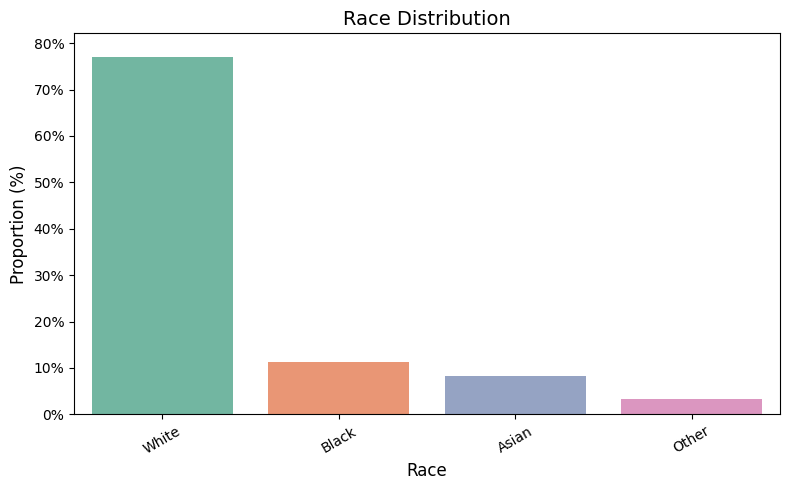

,race_recode,Proportion
0,White,0.771053
1,Black,0.112420
2,Asian,0.082595
3,Other,0.033932


In [ ]:
tabulate_and_plot(df_working, 'race_recode',
                  order=['White', 'Black', 'Asian', 'Other'],
                  title='Race Distribution', xlabel='Race')

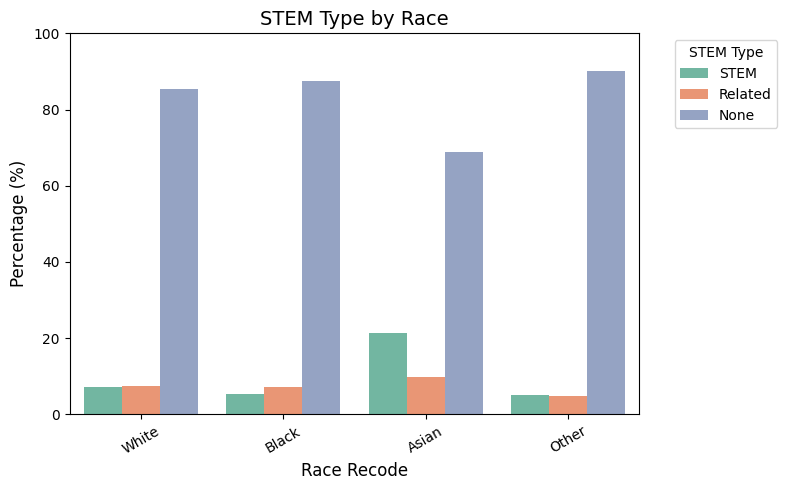

In [ ]:
plot_stem_share_by(df_working,
                   by_var='race_recode',
                   order=['White', 'Black', 'Asian', 'Other'],
                   title='STEM Type by Race')

### 4-2-3 Marriage Status

<ipython-input-125-cb258bb1a3c3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tab, x=var, y='Proportion', order=order, palette='Set2')


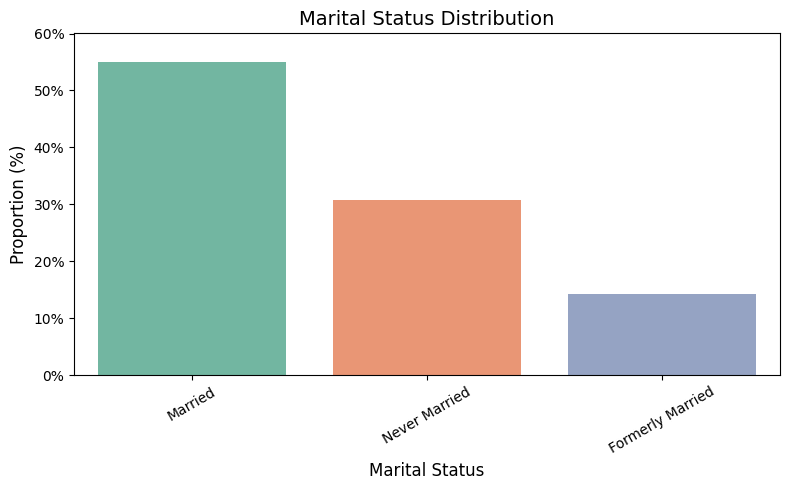

,marst_recode,Proportion
0,Married,0.550335
1,Never Married,0.307213
2,Formerly Married,0.142452


In [ ]:
tabulate_and_plot(df_working, 'marst_recode',
                  order=['Married', 'Never Married', 'Formerly Married'],
                  title='Marital Status Distribution', xlabel='Marital Status')

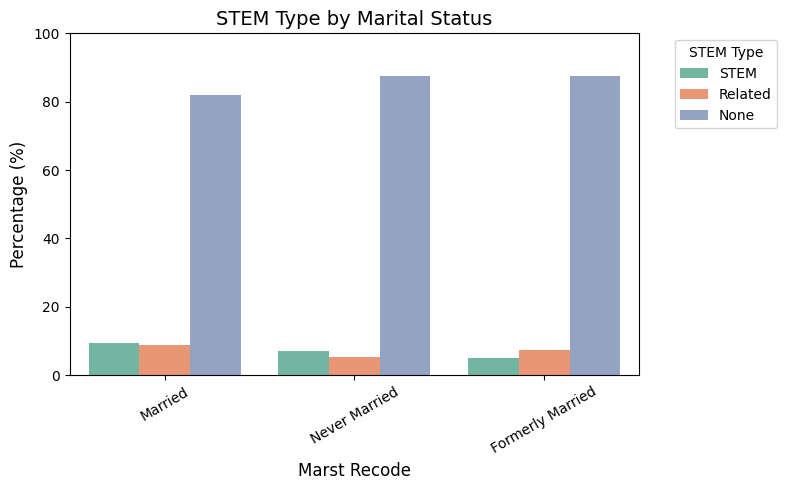

In [ ]:
plot_stem_share_by(df_working,
                   by_var='marst_recode',
                   order=['Married', 'Never Married', 'Formerly Married'],
                   title='STEM Type by Marital Status')

### 4-2-4 Citizenship

<ipython-input-125-cb258bb1a3c3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tab, x=var, y='Proportion', order=order, palette='Set2')


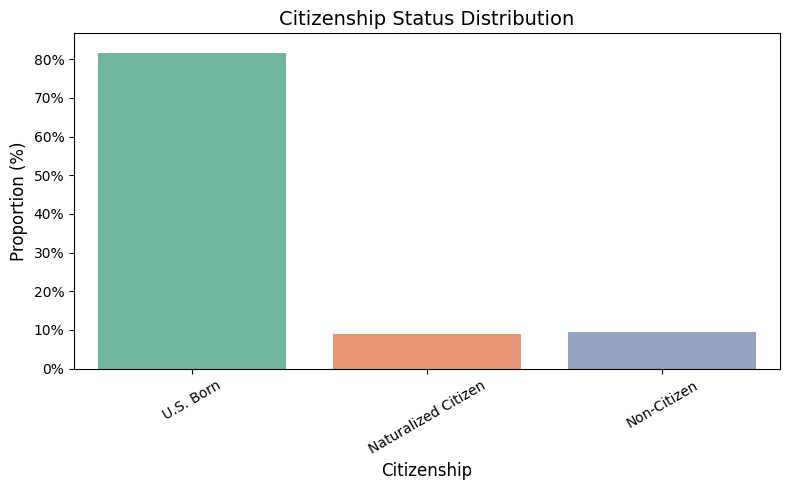

,citizen_recode,Proportion
0,U.S. Born,0.816957
1,Non-Citizen,0.093202
2,Naturalized Citizen,0.089841


In [ ]:
tabulate_and_plot(df_working, 'citizen_recode',
                  order=['U.S. Born', 'Naturalized Citizen', 'Non-Citizen'],
                  title='Citizenship Status Distribution', xlabel='Citizenship')

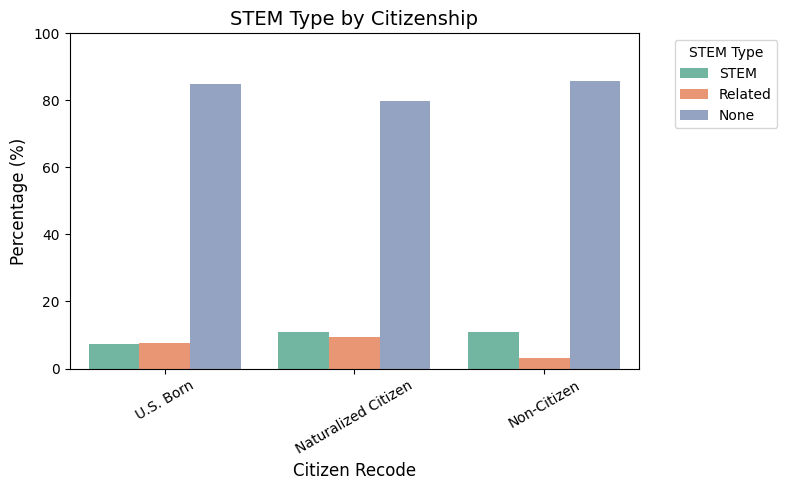

In [ ]:
plot_stem_share_by(df_working,
                   by_var='citizen_recode',
                   order=['U.S. Born', 'Naturalized Citizen', 'Non-Citizen'],
                   title='STEM Type by Citizenship')

### 4-2-5 Class of Work

<ipython-input-125-cb258bb1a3c3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tab, x=var, y='Proportion', order=order, palette='Set2')


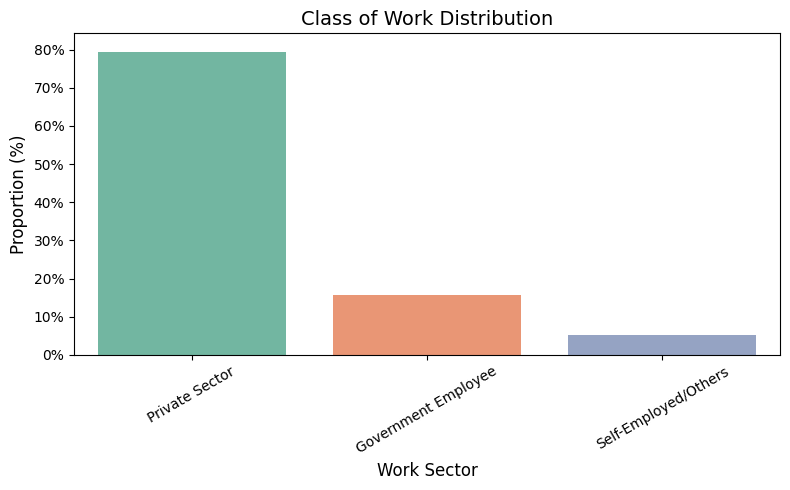

,classwkr_recode,Proportion
0,Private Sector,0.792839
1,Government Employee,0.156294
2,Self-Employed/Others,0.050867


In [ ]:
tabulate_and_plot(df_working, 'classwkr_recode',
                  order=['Private Sector', 'Government Employee', 'Self-Employed/Others'],
                  title='Class of Work Distribution', xlabel='Work Sector')

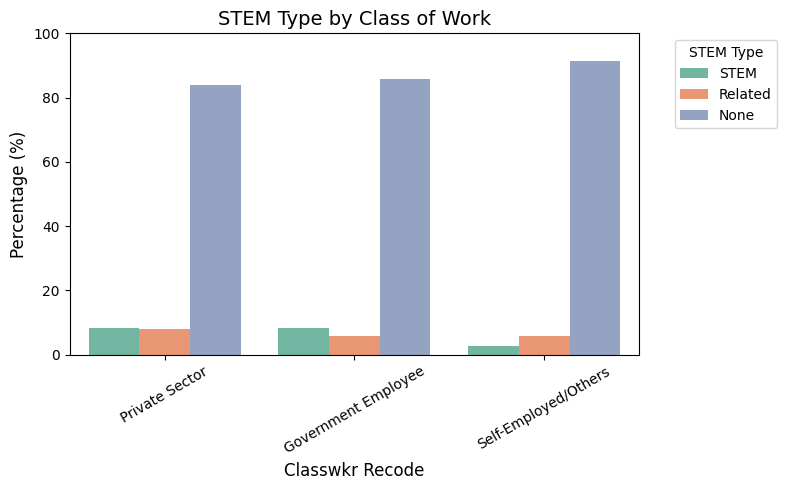

In [ ]:
plot_stem_share_by(df_working,
                   by_var='classwkr_recode',
                   order=['Private Sector', 'Government Employee', 'Self-Employed/Others'],
                   title='STEM Type by Class of Work')

### 4-2-6 Work Time Group

<ipython-input-125-cb258bb1a3c3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tab, x=var, y='Proportion', order=order, palette='Set2')


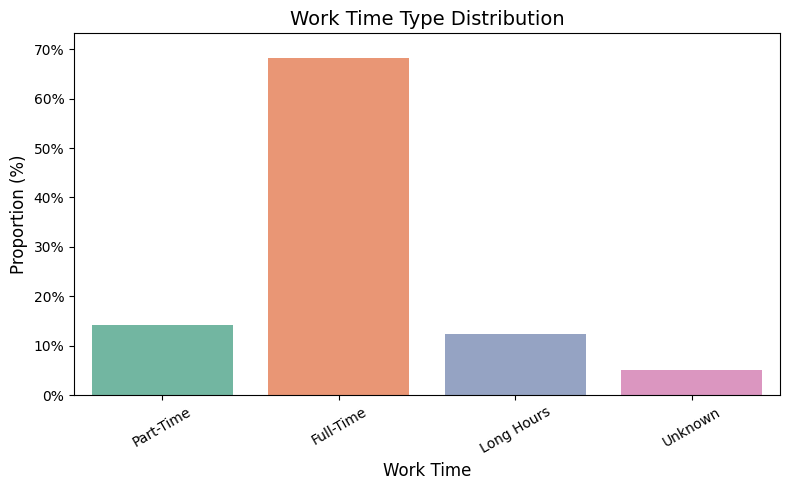

,worktime_group,Proportion
0,Full-Time,0.681830
1,Part-Time,0.141643
2,Long Hours,0.124455
3,Unknown,0.052072


In [ ]:
tabulate_and_plot(df_working, 'worktime_group',
                  order=['Part-Time', 'Full-Time', 'Long Hours', 'Unknown'],
                  title='Work Time Type Distribution', xlabel='Work Time')

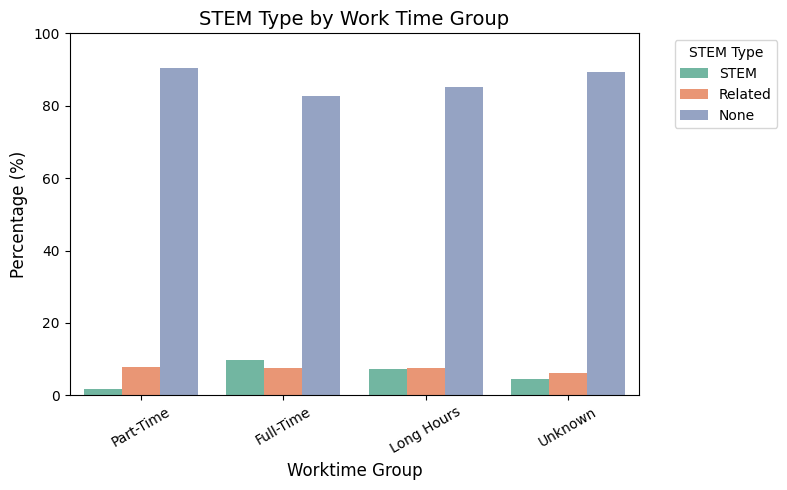

In [ ]:
plot_stem_share_by(df_working,
                   by_var='worktime_group',
                   order=['Part-Time', 'Full-Time', 'Long Hours', 'Unknown'],
                   title='STEM Type by Work Time Group')

### 4-2-7 Industry Sector

<ipython-input-125-cb258bb1a3c3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tab, x=var, y='Proportion', order=order, palette='Set2')


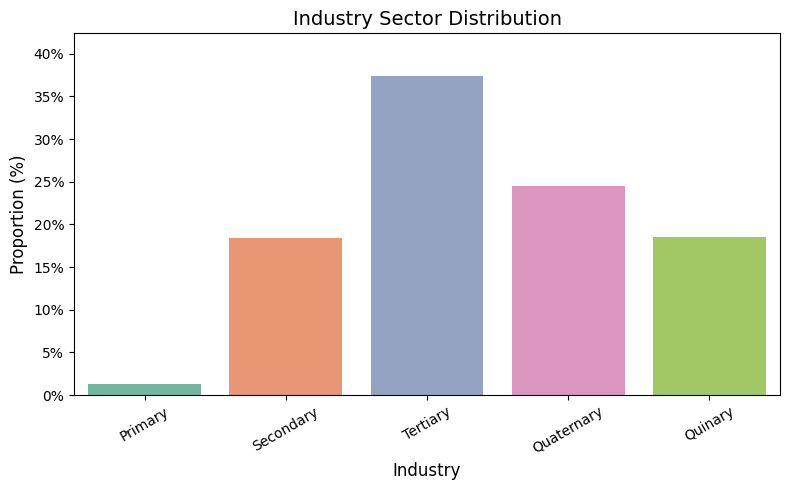

,industry_sector,Proportion
0,Tertiary,0.373967
1,Quaternary,0.244549
2,Quinary,0.184899
3,Secondary,0.183995
4,Primary,0.012590


In [ ]:
tabulate_and_plot(df_working, 'industry_sector',
                  order=['Primary', 'Secondary', 'Tertiary', 'Quaternary', 'Quinary'],
                  title='Industry Sector Distribution', xlabel='Industry')

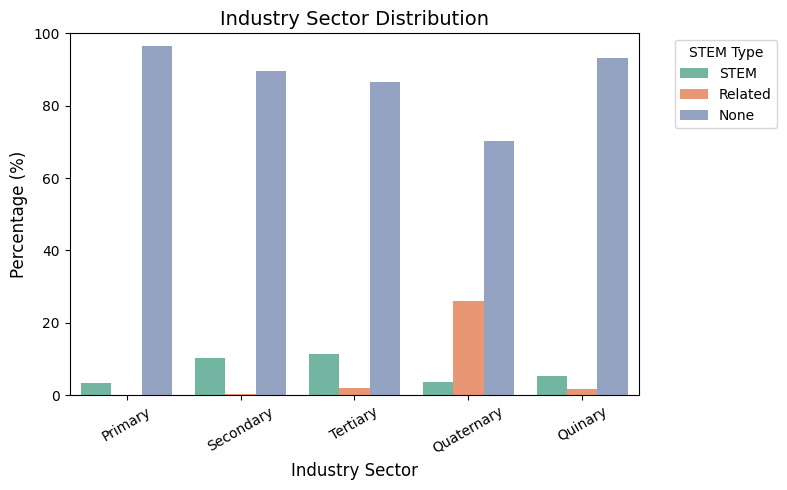

In [ ]:
plot_stem_share_by(df_working,
                   by_var='industry_sector',
                   order=['Primary', 'Secondary', 'Tertiary', 'Quaternary', 'Quinary'],
                  title='Industry Sector Distribution')

### 4-2-8 Age Group

<ipython-input-125-cb258bb1a3c3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tab, x=var, y='Proportion', order=order, palette='Set2')


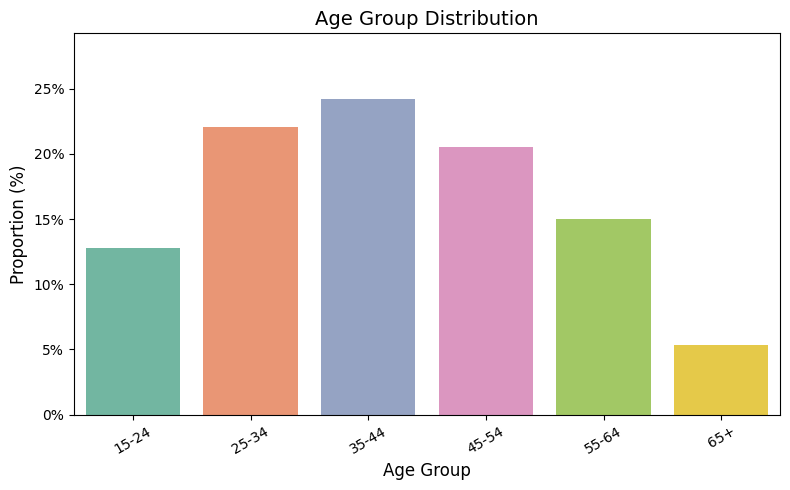

,age_group,Proportion
0,35-44,0.242499
1,25-34,0.220976
2,45-54,0.205426
3,55-64,0.150372
4,15-24,0.127643
5,65+,0.053084


In [ ]:
tabulate_and_plot(df_working, 'age_group',
                   order=['15-24', '25-34', '35-44', '45-54', '55-64', '65+'],
                   title='Age Group Distribution')

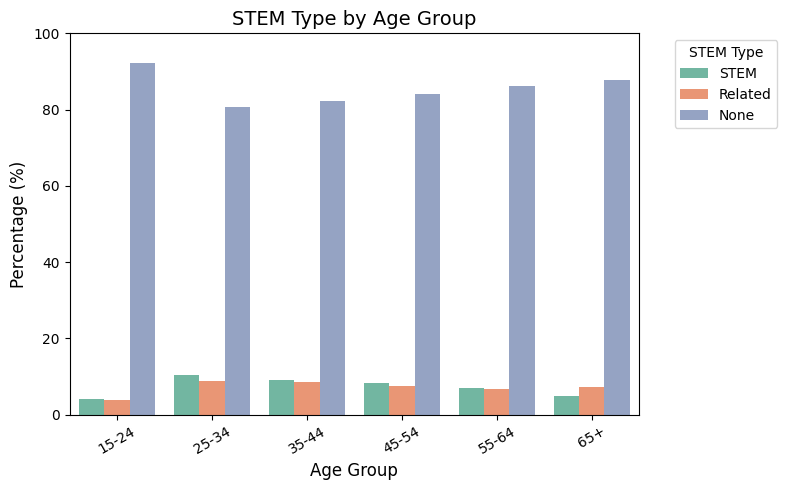

In [ ]:
plot_stem_share_by(df_working,
                   by_var='age_group',
                   order=['15-24', '25-34', '35-44', '45-54', '55-64', '65+'],
                   title='STEM Type by Age Group')

### 4-2-8 Outcome Variables



<ipython-input-127-911b0c347a49>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


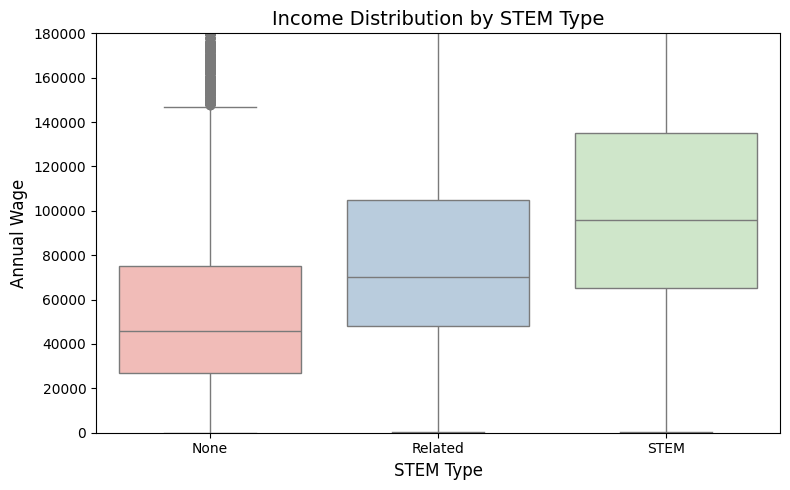

Median incwage by STEM type:  stem_type
None       46000.0
Related    70003.0
STEM       95750.0
Name: incwage, dtype: float64


<ipython-input-127-911b0c347a49>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = df.groupby('stem_type')[income_var].median()


In [ ]:
# incwage
plot_income_box(df_working, income_var='incwage', title='Income Distribution by STEM Type', ylabel='Annual Wage')

In [ ]:
# 1. Income (Annual Wage)
print("Annual Income (incwage):")
print("Min:", df_working["incwage"].min())
print("Max:", df_working["incwage"].max())


Annual Income (incwage):
Min: 2
Max: 1549999


In [ ]:
# 1. Annual Income Range by STEM Type
df_working.groupby('stem_type')['incwage'].agg(['min', 'max'])

<ipython-input-161-196c282c0552>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_working.groupby('stem_type')['incwage'].agg(['min', 'max'])


,min,max
stem_type,,
None,2,1549999
Related,500,1099999
STEM,150,1099999


<ipython-input-127-911b0c347a49>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


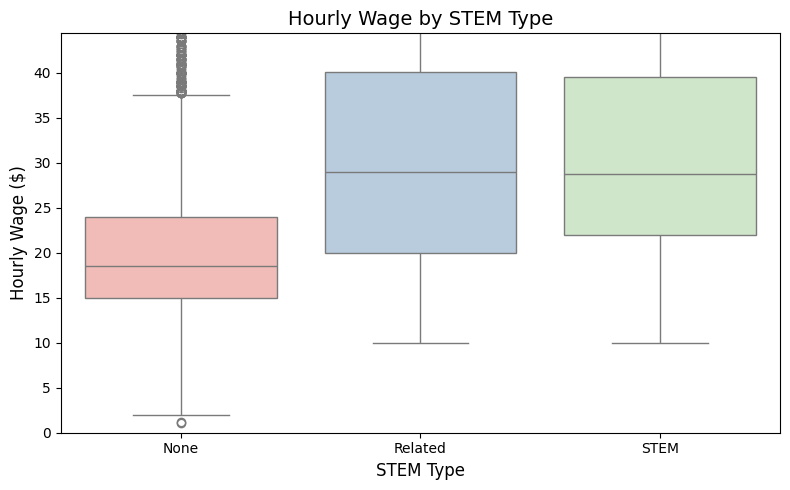

Median hourwage2 by STEM type:  stem_type
None       18.55
Related    29.00
STEM       28.75
Name: hourwage2, dtype: float64


<ipython-input-127-911b0c347a49>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = df.groupby('stem_type')[income_var].median()


In [ ]:
# hourwage2
plot_income_box(df_hourwage, income_var='hourwage2', title='Hourly Wage by STEM Type', ylabel='Hourly Wage ($)')

In [ ]:
# 2. Hourly Wage
print("\nHourly Wage (hourwage2):")
print("Min:", df_hourwage["hourwage2"].min())
print("Max:", df_hourwage["hourwage2"].max())


Hourly Wage (hourwage2):
Min: 1.1
Max: 63.04


In [ ]:
# 2. Hourly Wage Range by STEM Type
df_hourwage.groupby('stem_type')['hourwage2'].agg(['min', 'max'])

<ipython-input-162-88761953ac91>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_hourwage.groupby('stem_type')['hourwage2'].agg(['min', 'max'])


,min,max
stem_type,,
None,1.1,63.04
Related,10.0,63.04
STEM,10.0,63.04


In [ ]:
print("Total rows:", len(df_hourwage))
print("Non-missing hourwage2:", df_hourwage['hourwage2'].count())
print("Missing hourwage2:", df_hourwage['hourwage2'].isna().sum())

Total rows: 5371
Non-missing hourwage2: 5371
Missing hourwage2: 0


### 4-2-9 STEM Type

<ipython-input-125-cb258bb1a3c3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tab, x=var, y='Proportion', order=order, palette='Set2')


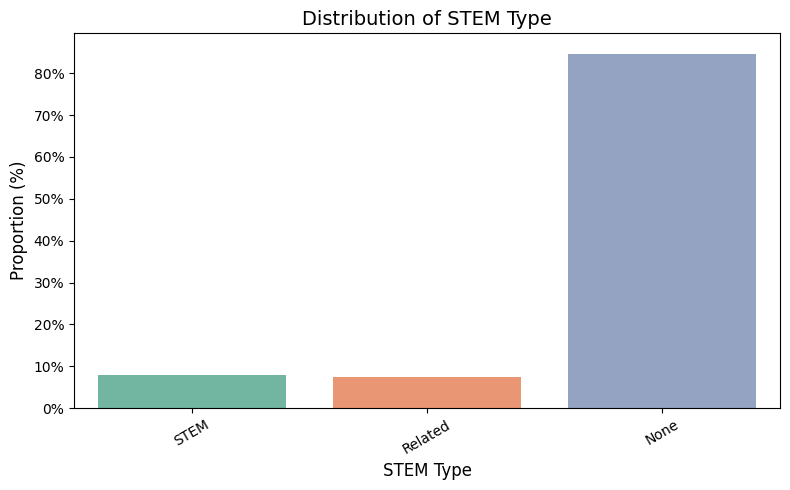

,stem_type,Proportion
0,None,0.845085
1,STEM,0.080105
2,Related,0.074809


In [ ]:
tabulate_and_plot(
    df=df_working,
    var='stem_type',
    order=['STEM', 'Related', 'None'],
    title='Distribution of STEM Type',
    xlabel='STEM Type'
)

### 4-2-10 Gender

<ipython-input-125-cb258bb1a3c3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tab, x=var, y='Proportion', order=order, palette='Set2')


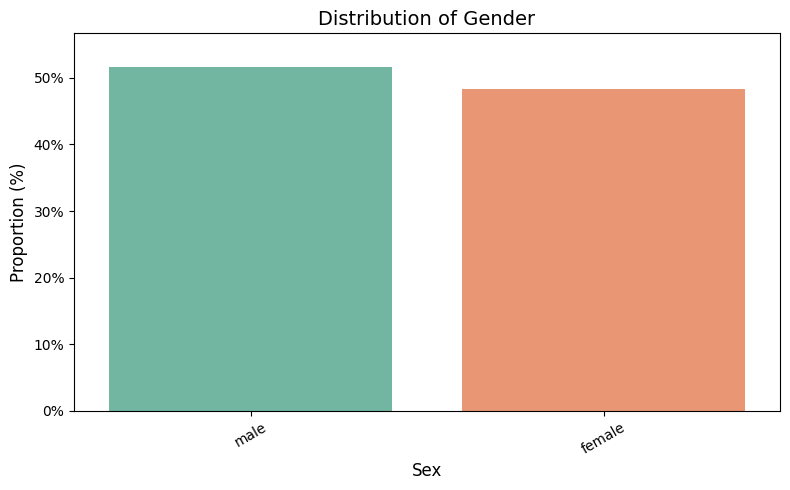

,sex,Proportion
0,male,0.517069
1,female,0.482931


In [ ]:
tabulate_and_plot(
    df=df_working,
    var='sex',
    title='Distribution of Gender',
)

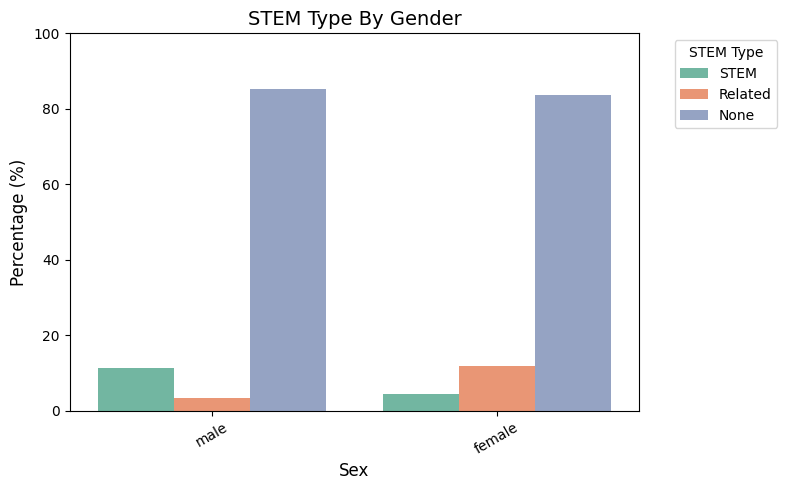

In [ ]:
plot_stem_share_by(df_working,
                   by_var='sex',
                  title='STEM Type By Gender')

# 5 OLS Regression

## 5-1 Research Question

This regression investigates whether working in a STEM occupation is associated with higher earnings, after accounting for demographic and job-related characteristics.

## 5-2 Regression

### 📑 Model Specification

**Dependent Variable (Y):**  
- Log of income (`log_incwage`)

**Key Independent Variable:**  
- `stem_type` (STEM, Related, None)

**Control Variables:**  
- Age group (`age_group`)  
- Sex (`sex`)  
- Education (simplified) (`educ_simple`)  
- Race (simplified) (`race_recode`)  
- Marital status (simplified) (`marst_recode`)  
- Citizenship status (simplified) (`citizen_recode`)  
- Class of worker (simplified) (`classwkr_recode`)  
- Industry sector (`industry_sector`)  
- Work hours (`worktime_group`)  
- Disability status (`diffany_dummy`)

**Interaction Term:**  
- `citizen_recode × stem_type`

$$
\begin{aligned}
\log(\text{incwage}_i) =\ & \beta_0
+ \beta_1 \cdot \text{STEMType}_{i}
+ \beta_2 \cdot \text{Citizenship}_{i}
+ \beta_3 \cdot (\text{STEMType}_{i} \times \text{Citizenship}_{i}) \\
& + \beta_4 \cdot \text{AgeGroup}_{i}
+ \beta_5 \cdot \text{Sex}_{i}
+ \beta_6 \cdot \text{Education}_{i}
+ \beta_7 \cdot \text{Race}_{i} \\
& + \beta_8 \cdot \text{MaritalStatus}_{i}
+ \beta_9 \cdot \text{ClassOfWork}_{i}
+ \beta_{10} \cdot \text{IndustrySector}_{i} \\
& + \beta_{11} \cdot \text{WorkTime}_{i}
+ \beta_{12} \cdot \text{Disability}_{i}
+ \varepsilon_i
\end{aligned}
$$


In [ ]:
formula = (
    "log_incwage ~ C(stem_type) + C(citizen_recode) + C(citizen_recode):C(stem_type) + "
    "C(age_group) + C(sex) + C(educ_simple) + C(race_recode) + "
    "C(marst_recode) + C(classwkr_recode) + C(industry_sector) + C(worktime_group) + "
    "diffany_dummy"
)

model = smf.ols(formula=formula, data=df_working).fit(cov_type='HC3')  # HC3 = robust

In [ ]:
model = smf.ols(formula=formula, data=df_working).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_incwage   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     1107.
Date:                Thu, 01 May 2025   Prob (F-statistic):               0.00
Time:                        23:20:22   Log-Likelihood:                -71105.
No. Observations:               62957   AIC:                         1.423e+05
Df Residuals:                   62923   BIC:                         1.426e+05
Df Model:                          33                                         
Covariance Type:                  HC3                                         
                                                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

### 📊 Regression Analysis Summary

The regression results examine the relationship between occupation type and annual income (`log_incwage`), controlling for demographic and job-related characteristics.

Due to the large sample size (n ≈ 63,000), I interpret results primarily based on **effect size** rather than statistical significance.


- **Field of Study (`stem_type`)**  
  Individuals working in STEM or STEM-related occupations earn significantly more than those in non-STEM fields.  
  - STEM-related: **+56.5%**  
  - STEM: **+48.3%**  
  These results suggest a strong income premium for technical and scientific occupations.

- **Citizenship and Interaction Effects**  
  Both U.S.-born and naturalized citizens earn more than non-citizens.  
  - U.S. Born: **+26.1%**  
  - Naturalized Citizen: **+17.2%**  
  However, the interaction terms suggest that the **income advantage of STEM jobs is smaller for citizens** than for non-citizens, indicating that non-citizens may experience higher relative gains from working in STEM.

- **Demographics**  
  - Income increases with age, peaking in the 45–54 group.  
  - Higher education is a strong predictor of income:
    - Associate’s: **+22.7%**  
    - Bachelor’s: **+50.3%**  
    - Graduate Degree: **+74.8%**  
  - Being married is positively associated with income, while never or formerly married individuals earn less.

- **Gender and Race**  
  - Females earn approximately **21.9% less** than males, controlling for other factors.  
  - Compared to White workers:
    - Black: **–5.0%**  
    - Asian: **+5.2%**  
    - Other: **–6.5%**

- **Employment and Industry**  
  - Private sector and self-employed workers earn slightly less than government employees.  
  - Workers in secondary and tertiary sectors earn more than those in Quinary.  
  - Working part-time is associated with a **sharp income penalty** (**–88.6%**), while long hours predict a modest gain (**+23.2%**).

- **Disability Status**  
  Having a disability is associated with a **13.7% reduction** in income.

- **Model Fit**  
  The model explains approximately **42.7%** of the variation in log-transformed income.


### Visualization of Coefficient

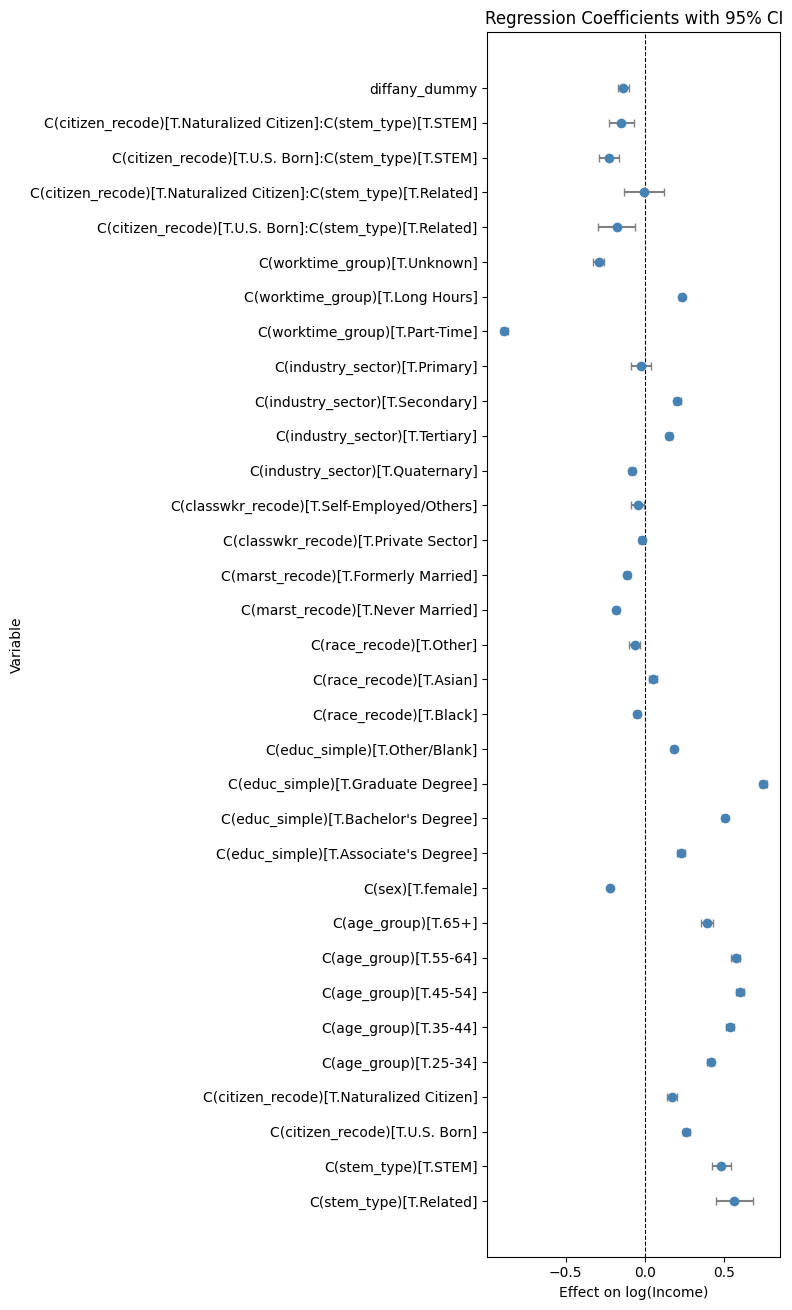

In [ ]:
coef_df = model.summary2().tables[1].reset_index()
coef_df.columns = ['Variable', 'Coef', 'Std Err', 't', 'P>|t|', 'CI Lower', 'CI Upper']

coef_plot = coef_df[coef_df['Variable'] != 'Intercept'].copy()

plt.figure(figsize=(8, len(coef_plot) * 0.4))
plt.errorbar(coef_plot['Coef'], coef_plot['Variable'],
             xerr=[coef_plot['Coef'] - coef_plot['CI Lower'], coef_plot['CI Upper'] - coef_plot['Coef']],
             fmt='o', color='steelblue', ecolor='gray', capsize=3)

plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Regression Coefficients with 95% CI')
plt.xlabel('Effect on log(Income)')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


### VIF Check

In [ ]:
y, X = dmatrices(formula, data=df_working, return_type='dataframe')

vif_df = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

print(vif_df.sort_values(by='VIF', ascending=False))


                                             Variable        VIF
0                                           Intercept  38.818381
1                             C(stem_type)[T.Related]  23.945692
29  C(citizen_recode)[T.U.S. Born]:C(stem_type)[T....  21.286829
2                                C(stem_type)[T.STEM]   8.804028
31  C(citizen_recode)[T.U.S. Born]:C(stem_type)[T....   7.619944
30  C(citizen_recode)[T.Naturalized Citizen]:C(ste...   3.938130
6                               C(age_group)[T.35-44]   3.057749
7                               C(age_group)[T.45-54]   2.981992
8                               C(age_group)[T.55-64]   2.565456
5                               C(age_group)[T.25-34]   2.541685
3                      C(citizen_recode)[T.U.S. Born]   2.248752
4            C(citizen_recode)[T.Naturalized Citizen]   2.243188
32  C(citizen_recode)[T.Naturalized Citizen]:C(ste...   2.220208
23                     C(industry_sector)[T.Tertiary]   2.165105
22                   C(in

Based on the VIF analysis, no variable shows problematic multicollinearity. All predictors are retained for the main regression model.

In [ ]:
# Export df_working as .dta
df_working.to_stata('df_working.dta', write_index=False)

<ipython-input-696-2c07a54025d9>:2: ValueLabelTypeMismatch: 
Stata value labels (pandas categories) must be strings. Column uhrsworkt contains
non-string labels which will be converted to strings.  Please check that the
Stata data file created has not lost information due to duplicate labels.

  df_working.to_stata('df_working.dta', write_index=False)
<ipython-input-696-2c07a54025d9>:2: ValueLabelTypeMismatch: 
Stata value labels (pandas categories) must be strings. Column uhrswork1 contains
non-string labels which will be converted to strings.  Please check that the
Stata data file created has not lost information due to duplicate labels.

  df_working.to_stata('df_working.dta', write_index=False)
<ipython-input-696-2c07a54025d9>:2: ValueLabelTypeMismatch: 
Stata value labels (pandas categories) must be strings. Column earnweek2 contains
non-string labels which will be converted to strings.  Please check that the
Stata data file created has not lost information due to duplicate labels